# Conjugate Gradient 기법 공부

In [38]:
from scipy.io import loadmat
import scipy.sparse as ssp
import scipy.sparse.linalg as ssp_linalg
import numpy as np
import cupy as cp
import time
import cupyx.scipy.sparse as csp
import cupyx.scipy.sparse.linalg as csp_linalg

from matplotlib import pyplot as plt

## Condition Number

행렬 A의 민감도를 나타내는 값

선형 시스템 $A\mathbf{x} = \mathbf{b}$를 풀 때 입력 데이터($\mathbf{b}$ 또는 $A$)에 작은 오차가 발생했을 때 해($\mathbf{x}$)가 얼마나 크게 변동하는지를 측정하는 척도.

조건수가 클수록 시스템은 불안정하고 해를 구하기 어렵다.

### 조건수의 정의 및 계산

조건수 $\text{cond}(A)$는 보통 Matrix Norm을 사용하여 정의한다

$$\text{cond}(A) = \|A\| \cdot \|A^{-1}\|$$

* $\|A\|$는 행렬 $A$의 norm이다.
* $\|A^{-1}\|$는 행렬 $A$의 역행렬 $A^{-1}$의 norm이다.

### Conjugate Gradientdhk의 관계

CG의 수렴 속도는 조건수 $\kappa = \text{cond}(A)$에 의해 결정되며 다음 부등식으로 나타낸다.

$$\frac{\| \mathbf{x}_k - \mathbf{x} \|_A}{\| \mathbf{x}_0 - \mathbf{x} \|_A} \leq 2 \left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k$$

* 조건수가 클수록 오차가 천천히 감소 = 수렴 속도 감소 (행렬이 ill-conditioned 상태가 나쁨)
* 조건수가 작을수록 오차가 빠르게 감소 = 수렴 속도 빠름 (행렬이 well-conditioned 상태가 좋음)
* 조건수가 무한이면 A는 Singular Matrix로 해가 없거나 무수히 많은 상태(CG 적용 불가)

### CG 성능 개선을 위한 방법: Preconditioning

새로운 시스템 $M^{-1} A \mathbf{x} = M^{-1} \mathbf{b}$을 풀어 변환된 행렬 $M^{-1}A$의 조건수를 1에 가깝게 만들어 수렴 속도를 높이는 방법


In [ ]:
def cond(A):
    """
    최적화 필요 이대로하면 A클수록 안될 가능성이 있음
    
    """
    cn = np.linalg.det(A) * np.linalg.det(ssp_linalg.inv(A))
    return cn

## 대각도 (Diagonal Dominance)

대각도는 정사각 행렬 $A$의 각 행에서 대각 성분이 다른 비대각 성분들에 비해 얼마나 큰지를 나타내는 성질이다.

행렬 $A = (a_{ij})$가 강한 대각 우위(Strictly Diagonally Dominant)를 갖는다는 것은 모든 행 $i$에 대해 다음 부등식을 만족하는 것을 의미한다

$$|a_{ii}| > \sum_{j \neq i} |a_{ij}|$$

* **$|a_{ii}|$**: $i$행의 대각 성분(Diagonal Element)의 절댓값.
* **$\sum_{j \neq i} |a_{ij}|$**: $i$행의 모든 비대각 성분(Off-Diagonal Elements) 절댓값의 합.

### CG 성능에 미치는 영향

대각 성분이 지배적일수록 (대각도가 강할수록) CG법의 성능은 향상됨.

* **높은 대각도 (강한 대각 우위)**:
    * ***행렬이 Positive Definite일 가능성이 높아짐***.
    * 행렬의 Condition Number가 작아지는 경향.
    * 결과적으로 CG와 같은 반복 해법의 수렴 속도가 빨라지고 해가 더 안정적이다.
* **낮은 대각도**:
    * 조건수가 커지고, 수렴 속도가 느려지며, 불안정해집니다.

## 대역폭 (Bandwidth)

대역폭은 희소 행렬에서 0이 아닌 성분들이 주대각선을 중심으로 얼마나 가깝게 분포되어 있는지를 나타내는 척도이다.

행렬 $A$의 대역폭(Bandwidth, $W$)은 행렬의 모든 0이 아닌 성분 $a_{ij} \neq 0$에 대해 다음 값의 최댓값으로 정의한다

$$W = \max \{ |i - j| \mid a_{ij} \neq 0 \}$$

* 행렬의 대역폭이 작을수록 행렬은 Band Matrix의 형태에 가까워집니다.
* $|i-j|$는 주대각선($i=j$)으로부터의 거리를 나타냅니다.

### CG 성능에 미치는 영향

대역폭은 행렬-벡터 곱셈($A\mathbf{x}$)의 효율성과 메모리 접근 패턴에 영향을 준다.

* **좁은 대역폭 (Small Bandwidth)**:
    * 0이 아닌 성분(Non-zeros, $\text{nnz}$)들이 대각선 근처에 집중되어 있어 구조적 이점을 활용하기 쉽다.
    * 직접 해법의 경우 메모리 사용량과 계산 복잡도를 크게 줄여준다 (대각선 근처만 계산).
    * GPU 기반 계산에서는 메모리 접근 패턴이 규칙적이어서 데이터 지역성(Locality)을 높이고 병렬 처리 효율을 향상시킬 수 있다.
* **넓은 대역폭 (Large Bandwidth)**:
    * 0이 아닌 성분들이 행렬 전체에 넓게 퍼져 있어 계산의 복잡성이 증가하고 메모리 접근이 불규칙해져 효율이 떨어질 수 있다.

#### 참고 : 대역폭 감소 기법

대역폭이 넓은 희소 행렬을 처리할 때, 행과 열의 순서를 변경하여 대역폭을 줄이는 **재배열(Reordering)** 기법(예: Cuthill-McKee 알고리즘)을 사용하기도 합니다. 이를 통해 행렬의 저장 효율과 계산 성능을 개선할 수 있습니다. 

## 시스템 A행렬 생성
- 강한 대각도를 부여하여 positive definite한 행렬
- Symetric한 행렬을 생성해 conjugate gradient method 활용 가능

In [39]:
def make_A(n, W, diag=1.0):
    """
    주어진 크기(n)와 대역폭(W)을 갖는 symetric, positive definite, sparse matrix 생성

    parameters
    ---------------------------
    n: 행렬의 크기 (n x n)
    W: 대역폭  1 <= W < n,  W=1은 3중 대각 행렬을 의미.
    diag: 대각 우위의 정도. 값이 클수록 대각 성분이 지배적

    return
    ---------------------------
    A : CSR 형식의 symetric, positive definite, sparse matrix (dtype=float32)
    """
    if W < 1 or W >= n:
        raise ValueError("bandwidth 범위 오류")

    # 1. 0이 아닌 성분들의 인덱스 생성
    # 대역폭 W 이내의 인덱스만 고려하여 i, j 배열생성
    rows = []
    cols = []
    data = []
    
    # Upper Triangle 부분만 생성하여 대칭성 보장
    for i in range(n):
        for j in range(i, min(n, i + W)): # 주대각선(j=i)부터 대역폭 W까지
            
            # 2. 비대각 성분의 값 설정 (a_ij, i != j)
            if i != j:
                # 무작위 값을 사용
                val = np.random.rand() * 0.5  
                
                rows.append(i)
                cols.append(j)
                data.append(val)
                
                # 대칭 성분 추가 (a_ji = a_ij)
                rows.append(j)
                cols.append(i)
                data.append(val)
    
    # 3. 대각 성분의 값 설정 (a_ii)
    # 각 행의 비대각 성분 합보다 큰 값을 부여하여 '대각 우위'를 만듭니다.
    # 이는 행렬의 양의 정부호성을 보장하는 일반적인 방법입니다.
    
    # 비대각 성분의 절댓값 합을 계산 (대략적인 값)
    off_diag_sum = np.zeros(n)
    for r, c, val in zip(rows, cols, data):
        if r != c:
            off_diag_sum[r] += abs(val)

    # 대각 성분 생성 (a_ii > sum(|a_ij|))
    for i in range(n):
        diag_val = off_diag_sum[i] * diag + 1.0 + np.random.rand() * 5.0
        
        rows.append(i)
        cols.append(i)
        data.append(diag_val)
    
    # 4. 희소 행렬 생성 (COO -> CSR 형식)
    A = ssp.coo_matrix((data, (rows, cols)), shape=(n, n), dtype=np.float32)
    
    # 5. 생성된 행렬의 정보 출력
    print(f"생성된 행렬의 크기: {A.shape}")
    print(f"0이 아닌 성분 개수 (nnz): {A.nnz}\n")
    
    return A

## 시스템 b 벡터와 오차
- 계산 결과를 위해서 Ax=b에서 b벡터를 x_true로부터 구성
- 오차는 RMSE를 이용

In [40]:
def make_b(A, x_true=None):
    """
    계산이 가능하도록 x_true로부터 b벡터를 구성
    

    parameters
    ------------------------------------
    A : symetric, positive definite matrix
    x_ture : Exact solution or random vector with length of row or column of A matrix


    return
    ------------------------------------
    b : RHS of system Ax=b with parameter A and solution x_true
    x_true : return for check error from computing
    """
    n = A.shape[0]

    if x_true == None:
        x_true = np.random.rand(n).astype(np.float32)
        b = A.dot(x_true).astype(np.float32)
    else:
        b = A.dot(x_true).astype(np.float32)

    return b, x_true


def rmse(a,b):
    """
    Compute RMSE error

    parameters
    --------------------------
    a : Array
    b : Array


    return
    --------------------------
    RMSE error

    """
    return np.sqrt(np.mean((a - b)**2))

## 계산 시간 분석과 Matrix 형상

- GPU계산 시간 편차가 너무 큼, CPU는 비교적 일정(시간 리스트로 확인할것)
- 오차를 정의하는 방법
- A 행렬이 너무 규칙적임 랜덤하게 생성할순 없을까?

In [41]:
def cal_time(a):
    """
    A 행렬을 받아와 conjugate gradient method로 Ax=b 계산 시간 비교
    b, x는 make_b 함수로부터 계산
    데이터 타입은 모두 float32로 통일

    parameters
    -------------------------
    a : sparse, symetric, positive definite matrix


    return
    -------------------------
    t_cpu : Computing time for Ax=b in CPU
    t_gpu : Computing time for Ax=b in GPU
    """
    
    b, x = make_b(a)

    a = ssp.csr_matrix(a, dtype=np.float32)
    A = csp.csr_matrix(a, dtype=np.float32)
    B = cp.asarray(b, dtype=np.float32)   # 이거는 cpu to gpu같은거

    t_cpu= 0
    t_gpu = 0

    for i in range(5):
        ts_cpu = time.time()
        sol_cpu, r_cpu = ssp_linalg.cg(a, b)
        te_cpu = time.time()
        t_cpu += te_cpu-ts_cpu

    for j in range(5):
        ts_gpu = time.time()
        sol_gpu, r_gpu = csp_linalg.cg(A, B)
        te_gpu = time.time()
        t_gpu += te_gpu-ts_gpu
    sol_gpu = sol_gpu.get()

    # scipy와 cupyx.scipy에서 계산 후 반환값이 0 이면 max iter도달 전 수렴했다는 의미
    if r_cpu == 0 and r_gpu == 0:
        diff = rmse(sol_cpu, sol_gpu)
        print(f'Exact solution = {x}\n')
        print(f'CPU solution RMSE Error = {rmse(sol_cpu, x)}')
        print(f'GPU solution RMSE Error = {rmse(sol_gpu, x)}\n')
        if diff > 1e-5:
            raise ValueError(f"Solution doesn't match : {diff}")
        else:
            print(f'cpu 계산시간 = {t_cpu/5}(s)')
            print(f'gpu 계산시간 = {t_gpu/5}(s)\n')
            print(f'GPU 성능은 CPU의 {t_cpu/t_gpu}배')
    else:
        raise ValueError('Solution not converged')

    return t_cpu/5, t_gpu/5


def plot_sparse(a):
    """
    sparse matrix A의 원소 분포를 plot하는 함수, 값이 존재하면 검은색 아니면 흰색

    parameters
    ---------------------
    a : sparse, symetric, positive definite matrix from function 'make_A'

    """

    n = a.shape[0]

    if ssp.issparse(a):
        plt.figure(figsize=(8,8))
        plt.spy(a, color = 'k', markersize=0.1)
        plt.title(f'Matrix pattern ({n}x{n}, non-zeros: {a.nnz})')
        plt.xlabel('column')
        plt.ylabel('row')

    else:
        print("A is not a sparse matrix")
        return

In [51]:
ns = [20000, 40000, 60000, 80000, 100000]
W = 100

ts_cpu=[]
ts_gpu=[]

for n in ns:
    a = make_A(n, W)
    t_cpu, t_gpu = cal_time(a)
    ts_cpu.append(t_cpu)
    ts_gpu.append(t_gpu)

생성된 행렬의 크기: (20000, 20000)
0이 아닌 성분 개수 (nnz): 3970100

Exact solution = [0.14755288 0.9412023  0.80820775 ... 0.18329756 0.81709    0.12562889]

CPU solution RMSE Error = 6.071169082133565e-06
GPU solution RMSE Error = 6.067890808481025e-06

cpu 계산시간 = 0.03850107192993164(s)
gpu 계산시간 = 0.025062417984008788(s)

GPU 성능은 CPU의 1.536207398444055배
생성된 행렬의 크기: (40000, 40000)
0이 아닌 성분 개수 (nnz): 7950100

Exact solution = [0.11705117 0.11645133 0.5597992  ... 0.76060236 0.35164905 0.360295  ]

CPU solution RMSE Error = 6.948283498786623e-06
GPU solution RMSE Error = 6.943513199075824e-06

cpu 계산시간 = 0.0765913963317871(s)
gpu 계산시간 = 0.05066847801208496(s)

GPU 성능은 CPU의 1.511618255308937배
생성된 행렬의 크기: (60000, 60000)
0이 아닌 성분 개수 (nnz): 11930100

Exact solution = [0.76210105 0.297737   0.6379866  ... 0.27487412 0.14126378 0.85912764]

CPU solution RMSE Error = 5.574856004386675e-06
GPU solution RMSE Error = 5.570496796281077e-06

cpu 계산시간 = 0.1194808006286621(s)
gpu 계산시간 = 0.04767251014709473(s)

GPU

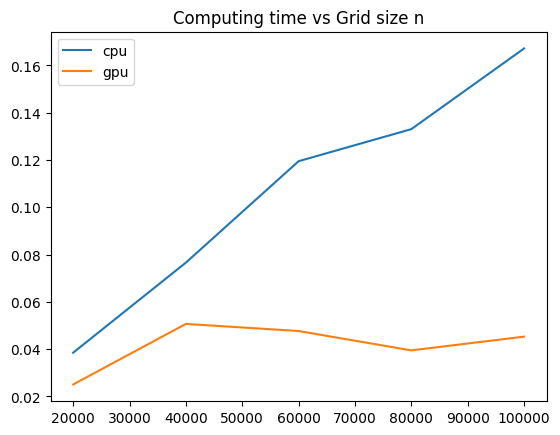

In [52]:
plt.plot(ns, ts_cpu, label='cpu')
plt.plot(ns, ts_gpu, label='gpu')
plt.title('Computing time vs Grid size n')
plt.legend()
plt.show()

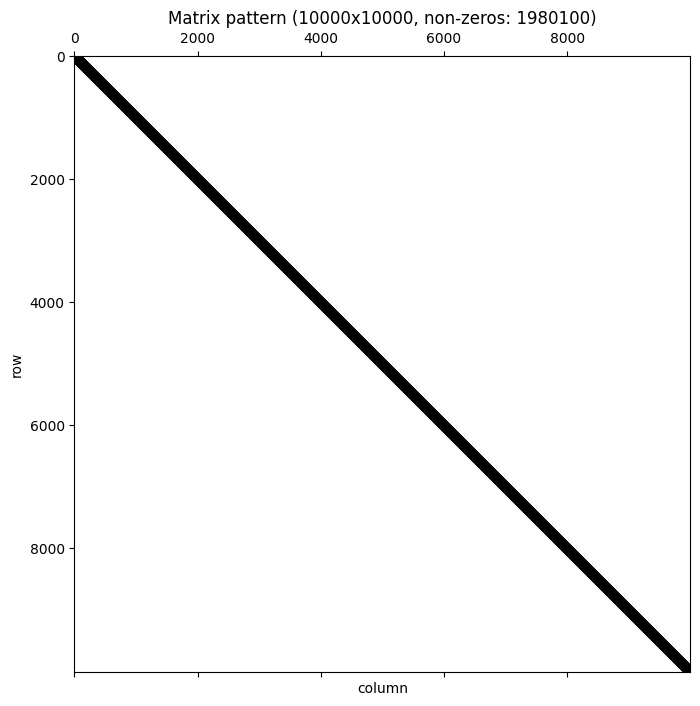

In [34]:
plot_sparse(a)